SUR et SOUS échantillonnage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier mis à jour
df = pd.read_csv('all_data_for_users_with_anomalies.csv')

# Calculer le nombre total d'utilisateurs uniques
total_users = df['user_number'].nunique()

print(f"Nombre total d'utilisateurs : {total_users}")


Nombre total d'utilisateurs : 68


In [2]:
df

,user_number,datetime,Consommation,cluster,anomalie,type
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie
...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie


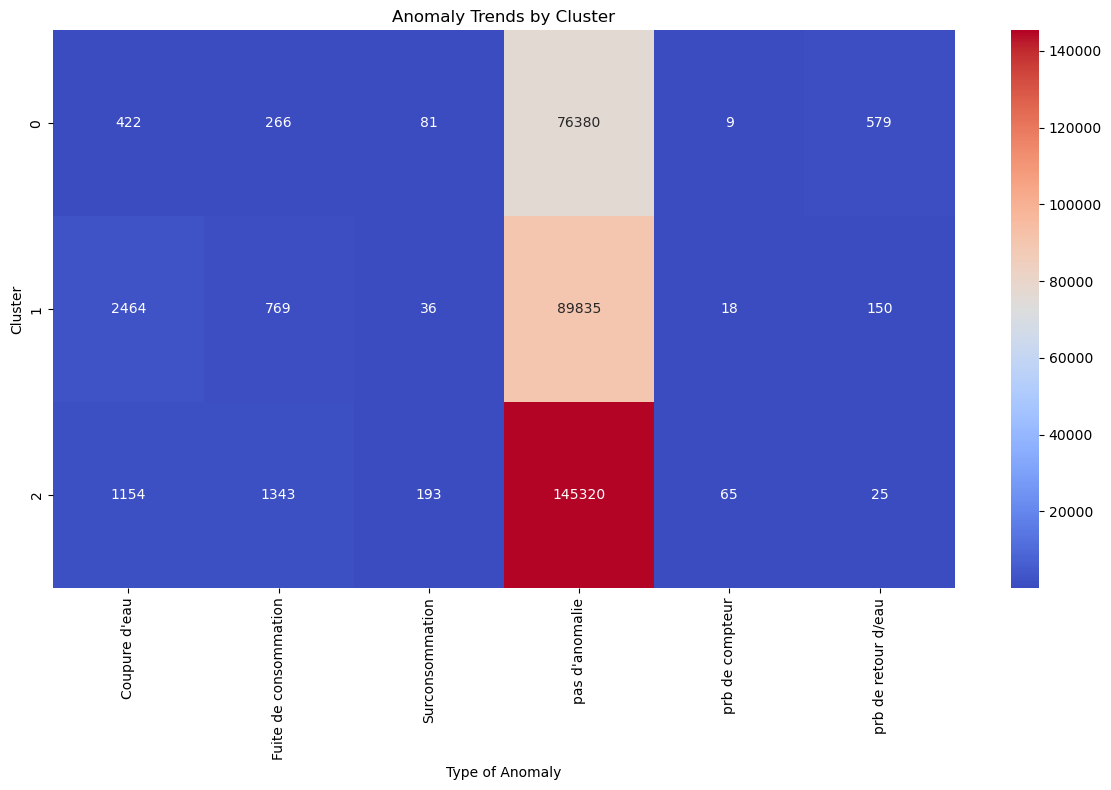

In [3]:
# Group by cluster and type of anomaly
cluster_anomalies = df.groupby(['cluster', 'type']).size().reset_index(name='count')

# Pivot the data for a heatmap
heatmap_data = cluster_anomalies.pivot(index='cluster', columns='type', values='count').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='coolwarm')

# Customize the heatmap
plt.title('Anomaly Trends by Cluster')
plt.xlabel('Type of Anomaly')
plt.ylabel('Cluster')
plt.tight_layout()

# Show the heatmap
plt.show()


Distribution des anomalies pour le cluster 0:
type
pas d'anomalie           76380
prb de retour d/eau        579
Coupure d'eau              422
Fuite de consommation      266
Surconsommation             81
prb de compteur              9
Name: count, dtype: int64
Distribution des anomalies pour le cluster 1:
type
pas d'anomalie           89835
Coupure d'eau             2464
Fuite de consommation      769
prb de retour d/eau        150
Surconsommation             36
prb de compteur             18
Name: count, dtype: int64
Distribution des anomalies pour le cluster 2:
type
pas d'anomalie           145320
Fuite de consommation      1343
Coupure d'eau              1154
Surconsommation             193
prb de compteur              65
prb de retour d/eau          25
Name: count, dtype: int64

Distribution des anomalies après rééquilibrage pour le cluster 0:
type
pas d'anomalie           2895
prb de retour d/eau       579
Coupure d'eau             579
Fuite de consommation     579
prb de compte

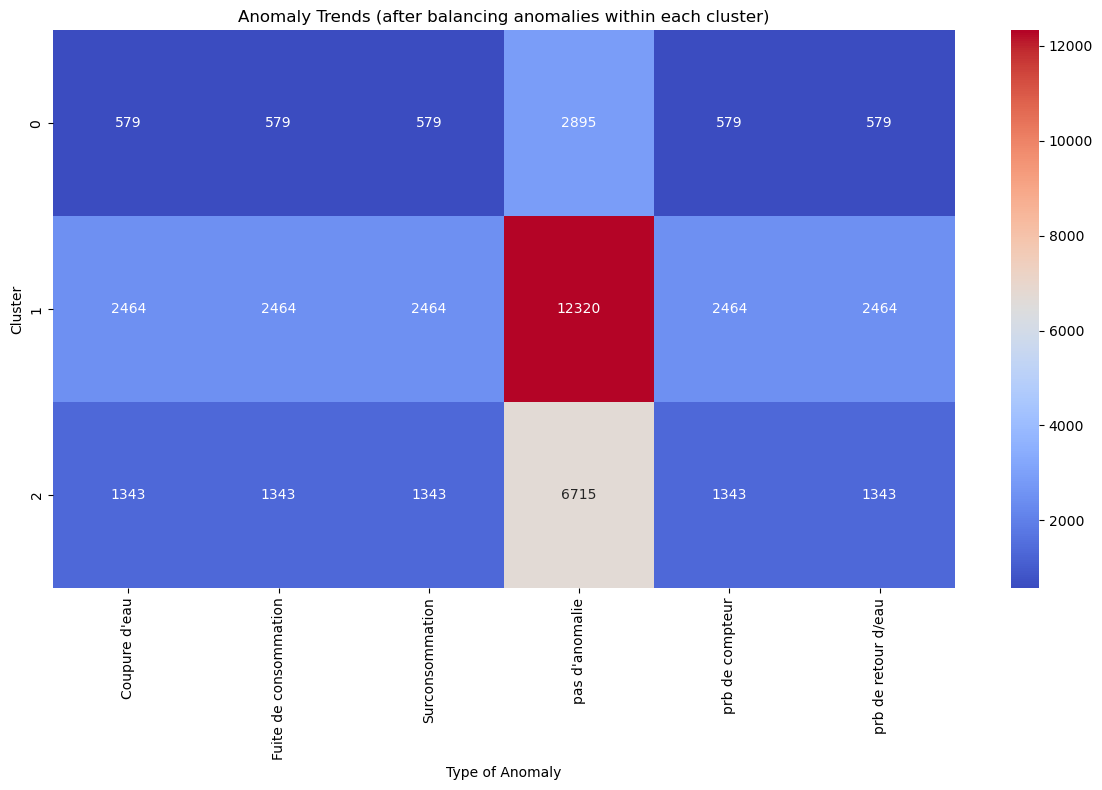

In [10]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier
df = pd.read_csv('all_data_for_users_with_anomalies.csv')

# Convertir la colonne 'datetime' en type datetime si nécessaire
df['datetime'] = pd.to_datetime(df['datetime'])

# Séparer les données par cluster
clusters = df['cluster'].unique()

# Liste pour stocker les données rééquilibrées
balanced_data = []

# Pour chaque cluster, on va appliquer SMOTE pour équilibrer les anomalies
for cluster in clusters:
    # Filtrer les données pour ce cluster
    cluster_data = df[df['cluster'] == cluster]
    
    # Comptage des types d'anomalies pour le cluster actuel
    anomaly_counts = cluster_data['type'].value_counts()
    print(f"Distribution des anomalies pour le cluster {cluster}:")
    print(anomaly_counts)
    
    # Séparer les anomalies "pas d'anomalie" des autres
    pas_anomalie = cluster_data[cluster_data['type'] == 'pas d\'anomalie']
    non_pas_anomalie = cluster_data[cluster_data['type'] != 'pas d\'anomalie']
    
    # Appliquer SMOTE uniquement sur les anomalies autres que "pas d'anomalie"
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_non_pas_anomalie = non_pas_anomalie[['Consommation', 'anomalie']]  # ou d'autres colonnes pertinentes
    y_non_pas_anomalie = non_pas_anomalie['type']
    
    X_smote, y_smote = smote.fit_resample(X_non_pas_anomalie, y_non_pas_anomalie)
    
    # Créer un DataFrame avec les anomalies rééchantillonnées (SMOTE)
    smote_data = pd.DataFrame(X_smote, columns=['Consommation', 'anomalie'])
    smote_data['type'] = y_smote.reset_index(drop=True)
    
    # Pour "pas d'anomalie", nous répliquons les données pour équilibrer la distribution
    pas_anomalie_replicated = pas_anomalie.sample(n=len(smote_data), replace=True, random_state=42)
    
    # Réintégrer les anomalies "pas d'anomalie" et les données SMOTE
    balanced_cluster_data = pd.concat([pas_anomalie_replicated, smote_data], axis=0, ignore_index=True)
    
    # Ajouter les informations des autres colonnes (user_number, datetime, cluster)
    balanced_cluster_data['user_number'] = pd.concat([pas_anomalie['user_number'], non_pas_anomalie['user_number']]).reset_index(drop=True)
    balanced_cluster_data['datetime'] = pd.concat([pas_anomalie['datetime'], non_pas_anomalie['datetime']]).reset_index(drop=True)
    balanced_cluster_data['cluster'] = cluster
    
    # Ajouter les données rééquilibrées pour ce cluster à la liste
    balanced_data.append(balanced_cluster_data)

# Fusionner toutes les données rééquilibrées en un seul DataFrame
balanced_df = pd.concat(balanced_data, axis=0, ignore_index=True)

# Afficher les nouvelles distributions des anomalies par cluster
for cluster in clusters:
    cluster_balance = balanced_df[balanced_df['cluster'] == cluster]['type'].value_counts()
    print(f"\nDistribution des anomalies après rééquilibrage pour le cluster {cluster}:")
    print(cluster_balance)

# Optionnel : Créer une carte thermique pour visualiser la répartition des anomalies par cluster
cluster_anomalies = balanced_df.groupby(['cluster', 'type']).size().reset_index(name='count')

# Créer la table pivotée pour la heatmap
heatmap_data_combined = cluster_anomalies.pivot(index='cluster', columns='type', values='count').fillna(0)

# Tracer la carte thermique pour les données équilibrées
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_combined, annot=True, fmt='.0f', cmap='coolwarm')

# Personnaliser la carte thermique
plt.title('Anomaly Trends (after balancing anomalies within each cluster)')
plt.xlabel('Type of Anomaly')
plt.ylabel('Cluster')
plt.tight_layout()

# Afficher la carte thermique
plt.show()


In [11]:
# Enregistrer le nouveau DataFrame rééquilibré dans un fichier CSV
balanced_df.to_csv('balanced_anomalies_data.csv', index=False)

# Afficher un message de confirmation
print("Le fichier rééquilibré a été sauvegardé sous le nom 'balanced_anomalies_data.csv'.")


Le fichier rééquilibré a été sauvegardé sous le nom 'balanced_anomalies_data.csv'.


In [12]:
# Charger la nouvelle base de données rééquilibrée
balanced_df = pd.read_csv('balanced_anomalies_data.csv')

# Calculer le nombre d'utilisateurs uniques dans chaque cluster
users_per_cluster = balanced_df.groupby('cluster')['user_number'].nunique()

# Afficher le nombre d'utilisateurs dans chaque cluster
print(users_per_cluster)


cluster
0    2
1    9
2    4
Name: user_number, dtype: int64


In [14]:
# Charger le fichier mis à jour
balanced_df = pd.read_csv('balanced_anomalies_data.csv')

# Calculer le nombre total d'utilisateurs uniques
total_users = balanced_df['user_number'].nunique()

print(f"Nombre total d'utilisateurs : {total_users}")


Nombre total d'utilisateurs : 15
